# Splitting the Smaller Posterior Files based on Velocity

From the previous Notebook, I figured out that it can actually be quite complicated because some of the components are actually quite broad in the velocity space so sometimes the red end of one component will overlap with the blue end of another, making it challenging to figure out where to set those velocity cutoffs for the bins. So what we are going to do instead is go through each of the smaller posterior files and make the velocity binnings off of that, where it should be easier to break things up because there should only be a few velocity components. This should also make it easier to sort out the purely noise components and also locate the more diffuse gas that is somehow evading the peak finder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy import units as u
import pickle
import math
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from tqdm import tqdm
from astropy.stats import sigma_clip

import os

%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
path = 'B213_velocity_posterior.fits'
cube = fits.open(path)
data = cube[0].data
header = cube[0].header
print(header)

wcs_b213 = wcs.WCS(header)
print(wcs_b213)
print(data.shape)

#If the beam size of the GBT at 23 GHz is 31 arcseconds, then 2 beam sizes is 62 arcseconds or 10.333 pixels

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -32 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                  343                                                  NAXIS2  =                  127                                                  NAXIS3  =                  199                                                  WCSAXES =                    3 / Number of coordinate axes                      CRPIX1  =                 47.0 / Pixel coordinate of reference point            CRPIX2  =               9715.0 / Pixel coordinate of reference point            CRPIX3  =                  0.0 / Pixel coordinate of reference point            CDELT1  =      -0.001666666707 / [deg] Coordinate increment at reference point  CDELT2  =       0.001666666707 / [deg] Coordinate increment at reference point  CDELT3  =    0.020100486924401 / [km/s] 

0.00043650428
131


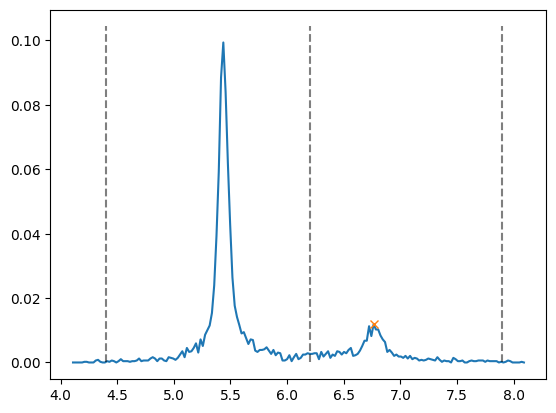

In [3]:
vel_start = header["CRVAL3"]
vel_inc = header["CDELT3"]

v_channels = np.arange(header["NAXIS3"])

#define velocity as km/s blocks
velocity = vel_start + (vel_inc * v_channels)
velocity = np.array(velocity, dtype = float)

posterior_dist = data[:, 7, 323]

print(np.std(posterior_dist[0:40]))

print(len(posterior_dist[68:]))

peaks, _ = find_peaks(posterior_dist[68:-1], height=np.nanmax(posterior_dist) * 0.05, 
                      distance = 20, 
                      prominence = np.nanmax(posterior_dist) * 0.05)#, 
                     #width = [1, 15])
heights = _['peak_heights']

#print(sorted(heights, reverse = True)[0])
#print(velocity[list(posterior_dist[68:]).index(sorted(heights, reverse = True)[0])+68])
#if velocity[list(posterior_dist[68:]).index(sorted(heights, reverse = True)[0])+68] < 7.0:
    #print('Yes')
    #print(list(posterior_dist[68:]).index(sorted(heights, reverse = True)[0]))
#else:
    #print('No')
#print(peaks)
#for i in range(len(peaks)):
    #print(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[i])])

plt.figure()
plt.plot(velocity, posterior_dist)
plt.plot(velocity[peaks+68], posterior_dist[peaks+68], "x")
plt.vlines(4.4, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
#plt.vlines(5.84, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.vlines(6.2, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)
plt.vlines(7.9, np.min(posterior_dist), np.max(posterior_dist)*1.05, colors = 'black', linestyle = 'dashed', alpha = 0.5)

plt.show()

In [4]:
peaks_grid_1 = []
for i in tqdm(range(126)):
    row_number_1 = []
    for j in range(342):
        posterior_dist = data[:, i, j]
        if math.isnan(np.sum(posterior_dist)):
            row_number_1.append(np.sum(posterior_dist))
        elif np.std(posterior_dist[3:30]) > 0.0011:
            row_number_1.append(data[0, 116, 247])
        elif 0 < j < 95 and 0 < i < 40:
            row_number_1.append(data[0, 116, 247])
        elif 145 < j < 246 and 120 < i < 140:
            row_number_1.append(data[0, 116, 247])
        elif 0 < j < 246 and 140 < i:
            row_number_1.append(data[0, 116, 247])
        elif 300 < j and i < 35:
            primary_peaks, _ = find_peaks(posterior_dist[68:], height=np.nanmax(posterior_dist) * 0.05, 
                                          distance = 20, 
                                          prominence = np.nanmax(posterior_dist) * 0.05)
            primary_heights = _['peak_heights']

            secondary_peaks, _ = find_peaks(posterior_dist, height=np.nanmax(posterior_dist) * 0.05, 
                                          distance = 20, 
                                          prominence = np.nanmax(posterior_dist) * 0.05)
            secondary_heights = _['peak_heights']
            #print(len(heights))
            if len(primary_heights) == 0:
                row_number_1.append(velocity[list(posterior_dist).index(sorted(secondary_heights, reverse = True)[0])])
            else:
                #print(i, j, list(posterior_dist).index(sorted(primary_heights, reverse = True)[0]))
                row_number_1.append(velocity[list(posterior_dist[68:]).index(sorted(primary_heights, reverse = True)[0])+68])
        else:
            peaks, _ = find_peaks(posterior_dist, height=np.nanmax(posterior_dist) * 0.05, 
                                  distance = 20, 
                                  prominence = np.nanmax(posterior_dist) * 0.05)
            heights = _['peak_heights']

            #specific_heights = []
            #for l in range(len(heights)):
                #specific_heights.append(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[0])])
            #bin_1 = []
            
            #for k in specific_heights:
                #bin_1.append(k)
                    
            row_number_1.append(velocity[list(posterior_dist).index(sorted(heights, reverse = True)[0])])
            
    peaks_grid_1.append(row_number_1)

100%|█████████████████████████████████████████████████████████████████████████████████| 126/126 [00:01<00:00, 67.94it/s]


/tmp/ipykernel_362879/3357263934.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('bwr')


6.743214030558731


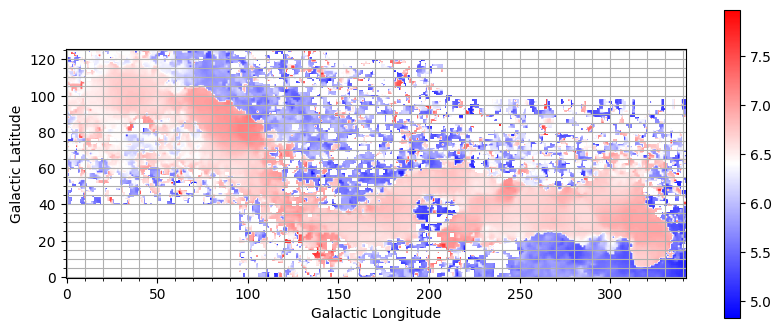

In [5]:
print(peaks_grid_1[6][320])

#plt.hist(peaks_grid_1)
#print(np.nanmedian(peaks_grid_1), np.nanstd(peaks_grid_1))

#sigma_mask = sigma_clip(peaks_grid_1, sigma = 1.1, maxiters = None, cenfunc = 'mean', grow = 1.5)
#newmask = (peaks_grid_1 < np.amax(sigma_mask))

#peaks_grid_masked = np.ma.array(peaks_grid_1, mask = newmask)
#plt.figure()
#plt.hist(peaks_grid_masked)

plt.figure(figsize = [10, 4])

ax = plt.subplot(111)#, projection = wcs_b213, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('bwr')
im = ax.imshow(peaks_grid_1, origin = 'lower', cmap = cm)
ax.grid(which = 'both')
plt.minorticks_on()
plt.colorbar(im)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

#ax = plt.subplot(212, projection = wcs_b10, slices=('x', 'y', 0))
#cm = plt.cm.get_cmap('bwr')
#im = ax.imshow(peaks_grid_1, origin = 'lower', cmap = cm)
#ax.grid()
#plt.minorticks_on()
##plt.colorbar(im)
#ax.set_xlabel('Galactic Longitude')
#ax.set_ylabel('Galactic Latitude')

output_hdu = wcs_b213.to_fits()
output_hdu[0].data is None

output_hdu[0].data = peaks_grid_1

output_hdu.writeto("B213_velocity_grid_blue.fits", overwrite=True)

#output_hdu = wcs_b213.to_fits()
#output_hdu[0].data is None

#output_hdu[0].data = peaks_grid_2

#output_hdu.writeto("B213_velocity_grid_red.fits", overwrite=True)

In [103]:
path = 'distance_transform.fits'
cube = fits.open(path)
distance_transform_data = cube[0].data
header = cube[0].header
#print(header)

wcs_dist_transform = wcs.WCS(header)

print(wcs_dist_transform)
print(distance_transform_data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(1100.0) np.float64(9785.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 2200  800
(800, 2200)


In [104]:
paper_coords = open('Seo Coordinates.txt').read().split()

strings = paper_coords
l_strings = []
b_strings = []
for i in range(39):
    l_strings.append(strings[i*4])
    b_strings.append(strings[i*4+1])

lat_paper = []
lon_paper = []
for i in range(39):
    lon_val = l_strings[i]
    lon_value = float(lon_val[0:3]) + float(lon_val[4:6])/60 + float(lon_val[7:11])/3600
    lon_paper.append(lon_value)

    lat_val = b_strings[i]
    lat_value = -float(lat_val[1:3]) - float(lat_val[4:6])/60 - float(lat_val[7:9])/3600
    lat_paper.append(lat_value)

#for i in range(39):
    #print(lon[i], lon_paper[i], lat[i], lat_paper[i])

c = SkyCoord(lon_paper, lat_paper, frame='galactic', unit='deg')

pixels_x, pixels_y = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_dist_transform, origin=1)
pixels_x_vel, pixels_y_vel = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_b213, origin=1)
#print(pixels_y)

print(lon[20], lat[20])

169.76131449036643 -16.171663941782043


/tmp/ipykernel_362879/643654232.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cm = plt.cm.get_cmap('magma_r')


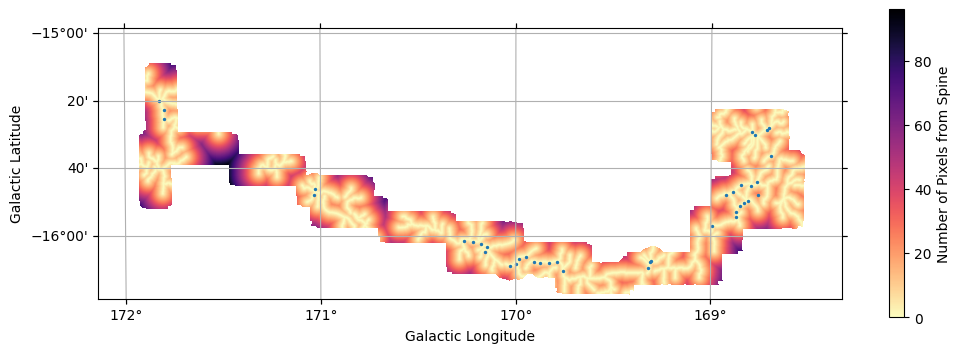

In [105]:
plt.figure(figsize = [12,4])
ax = plt.subplot(projection=wcs_dist_transform, slices=('x', 'y', 0))
cm = plt.cm.get_cmap('magma_r')
im = plt.imshow(distance_transform_data, origin = 'lower', cmap = cm)
plt.scatter(pixels_x, pixels_y, s = 2)
plt.colorbar(im, label = 'Number of Pixels from Spine')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.grid()

In [106]:
path = 'B213_velocity_grid_blue.fits'
cube = fits.open(path)
blue_data = cube[0].data
header = cube[0].header
#print(header)

wcs_blue = wcs.WCS(header)

print(wcs_blue)
print(blue_data.shape)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL' 'GLAT-SFL' 'v' 
CRVAL : np.float64(170.233333333) np.float64(0.0) np.float64(4.1100502434622) 
CRPIX : np.float64(47.0) np.float64(9715.0) np.float64(0.0) 
PC1_1 PC1_2 PC1_3  : np.float64(1.0) np.float64(0.0) np.float64(0.0) 
PC2_1 PC2_2 PC2_3  : np.float64(0.0) np.float64(1.0) np.float64(0.0) 
PC3_1 PC3_2 PC3_3  : np.float64(0.0) np.float64(0.0) np.float64(1.0) 
CDELT : np.float64(-0.001666666707) np.float64(0.001666666707) np.float64(0.020100486924401) 
NAXIS : 342  126
(126, 342)


In [107]:
list_ = open("Seo_NH3_peaks.txt").read().split()
strings = list_[4:]
ra_strings = []
dec_strings = []
for i in range(39):
    ra_strings.append(strings[i*3])
    dec_strings.append(strings[i*3+1])

#print(ra_strings)

ra = []
dec = []
for i in range(39):
    ra_val = ra_strings[i]
    ra_value = float(ra_val[0])*15 + 15*float(ra_val[2:4])/60 + 15*float(ra_val[5:11])/3600
    ra.append(ra_value)

    dec_val = dec_strings[i]
    dec_value = float(dec_val[0:2]) + float(dec_val[3:5])/60 + float(dec_val[6:11])/3600
    dec.append(dec_value)

c = SkyCoord(ra, dec, frame='icrs', unit='deg')
galactic_coords = c.galactic

lon = np.array(galactic_coords.l*u.degree)
lat = np.array(galactic_coords.b*u.degree)

#print(lon, lat)

c = SkyCoord(lon, lat, frame='galactic', unit='deg')

pixels_x, pixels_y = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_dist_transform, origin=1)
pixels_x_vel, pixels_y_vel = astropy.wcs.utils.skycoord_to_pixel(c, wcs = wcs_b213, origin=1)

print(pixels_x, pixels_y)

[1983.00099567 1977.00659142 1940.99932345 1931.00363939 1989.00429432
 1929.99552784 1901.00804597 1876.00148288 1856.0095826  1950.00173594
 1946.99592993 1920.0007664  1910.00581401 1898.00170899 1885.01048549
 1886.00883825 1813.02218266 1634.00871187 1632.00542148 1625.99943055
 1372.00506531 1354.99658538 1333.00722484 1305.00667122 1286.9984637
 1265.00556649 1242.00501774 1233.99762268 1217.00469284 1131.99829133
 1144.0045607  1149.99806787 1080.99658352 1106.99532831  638.0112226
  640.00320992  192.99502458  193.00604716  178.99681463] [503.00103732 498.00251159 482.00191129 493.00227809 422.00112205
 332.00180131 334.00185691 314.00223772 305.00220364 305.00271873
 343.00134712 289.00119797 281.00136666 272.00286091 254.00103804
 240.00150939 213.98527211 110.00099362 106.00107325  91.00089752
  82.00186974 108.00235488 104.00157711 105.0022492  107.00191761
 123.0013344  117.00121544 102.0010991   96.00281616 160.0022528
 138.00167838 151.00283848 171.00124395 167.0028346 

170.3131659755382 169.72017026400746
-16.190000391798 -15.980000386716
1053 1395
70 196
832.0104854889598 184.00103803981256


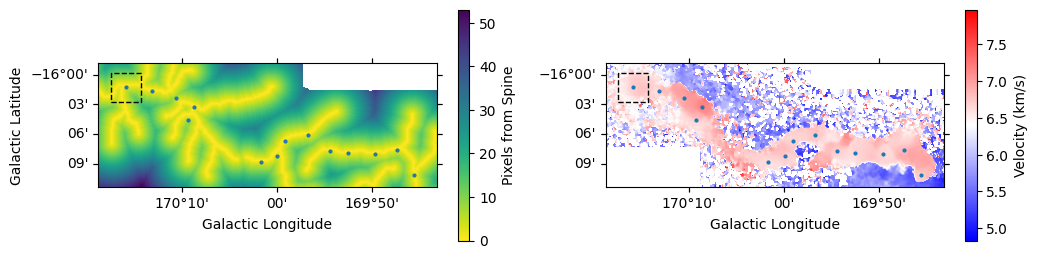

In [108]:
(l_min, b_min, vel), (l_max, b_max, vel) = wcs_b213.wcs_pix2world([[0, 0, 0], [342, 126, 0]], 0)

print(l_min, l_max)
print(b_min, b_max)

(l_min, b_min, vel), (l_max, b_max, vel) = wcs_dist_transform.wcs_world2pix([[l_min, b_min, 0], [l_max, b_max, 0]], 0)

print(round(l_min), round(l_max))
print(round(b_min), round(b_max))

#print(peaks_grid_1[129][109])

subregion = distance_transform_data[round(b_min):round(b_max), round(l_min):round(l_max)]

plt.figure(figsize = [12, 3])
ax_1 = plt.subplot(122, projection = wcs_b213, slices=('x', 'y', 0))
im = ax_1.imshow(peaks_grid_1, cmap = 'bwr')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_1.set(xlim=(0, 342), ylim=(0, 126))
cbar = plt.colorbar(im, label = 'Velocity (km/s)')
ax_1.add_patch(plt.Rectangle((13, 86), 30, 30, ls="--", ec="k", fc="none"))
#ax_1.add_patch(plt.Circle((109, 129), 1))
ax_1.scatter(pixels_x_vel, pixels_y_vel, s = 4)


ax_2 = plt.subplot(121, projection = wcs_dist_transform, slices=('x', 'y', 0))
im = ax_2.imshow(distance_transform_data, cmap = 'viridis_r', vmax = np.nanmax(subregion))
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
ax_2.set(xlim=(l_min, l_max), ylim=(b_min, b_max))
cbar = plt.colorbar(im, label = 'Pixels from Spine')
ax_2.add_patch(plt.Rectangle((l_min + 13, b_min +86), 30, 30, ls="--", ec="k", fc="none"))

ax_2.scatter(pixels_x, pixels_y, s = 4)

print(pixels_x_vel[14], pixels_y_vel[14])

30 30
30 30
30 30
30 30
30
[0.         0.5        0.70710678 1.         1.11803399 1.41421356]
23.192869528154976


/tmp/ipykernel_362879/2640881823.py:34: RuntimeWarning: invalid value encountered in scalar divide
  x_place.append(float(-grad_x_spines[i][j]/(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))))
/tmp/ipykernel_362879/2640881823.py:35: RuntimeWarning: invalid value encountered in scalar divide
  y_place.append(float(-grad_y_spines[i][j]/(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))))
/tmp/ipykernel_362879/2640881823.py:55: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (perp_x_spines[i][j] * grad_x_vel[i][j] + perp_y_spines[i][j] * grad_y_vel[i][j])/(np.sqrt((perp_x_spines[i][j])**2 + (perp_y_spines[i][j])**2))


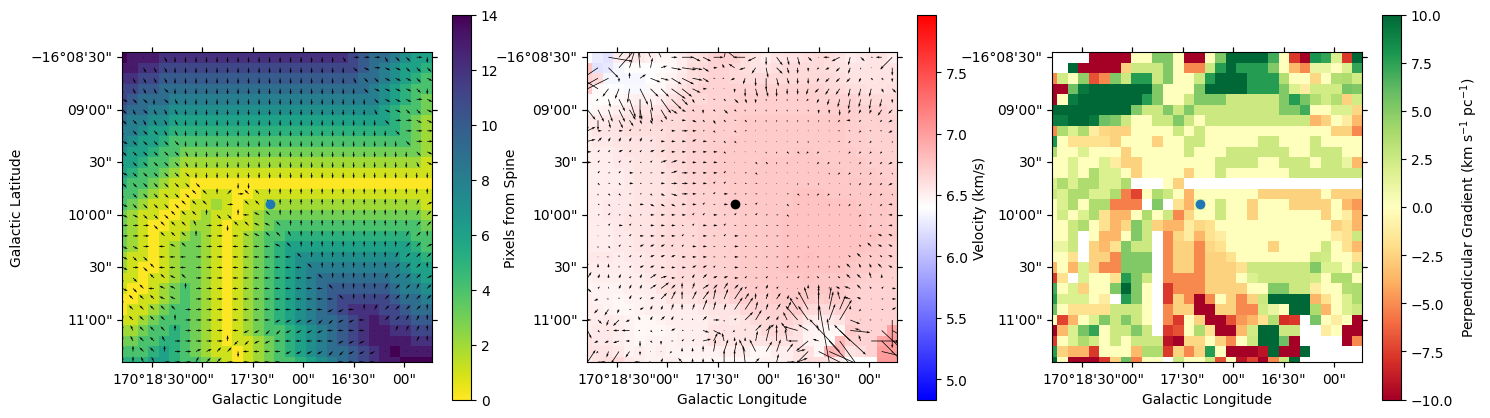

In [113]:
def divergence(scalar_field):
    gy, gx = np.gradient(scalar_field)
    print(len(gx[0]), len(gy[0]))
    return(gy, gx)

lon_length, lat_length = 30, 30
lon_start, lat_start = 14, 86

subregion_vel = blue_data[lat_start:lat_start + lat_length, lon_start:lon_start + lon_length]
grad_y_vel, grad_x_vel = divergence(subregion_vel) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_vel), len(grad_y_vel))

subregion_spines = distance_transform_data[round(b_min + lat_start):round(b_min + lat_start + lat_length), round(l_min + lon_start):round(l_min + lon_start + lon_length)]
grad_y_spines, grad_x_spines = divergence(subregion_spines) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_spines), len(grad_y_spines))

x = np.arange(0, lon_length, 1)
y = np.arange(0, lat_length, 1)

X, Y = np.meshgrid(x,y)

print(len(y))

perp_x_spines = []
perp_y_spines = []
diff_1_form_mag = []
for i in range(lat_length):
    x_place = []
    y_place = []
    for j in range(lon_length):
        #print(j, i, list(x_0).index(j), y_0[list(x_0).index(j)]) 
        #print x coord, y coord, the index of the spine in that column, the y coordinate of the spine in that column
        if subregion_spines[i][j] <= 12:
            x_place.append(float(-grad_x_spines[i][j]/(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))))
            y_place.append(float(-grad_y_spines[i][j]/(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))))
            diff_1_form_mag.append(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))
        else:
            x_place.append(float(0))
            y_place.append(float(0))
    perp_x_spines.append(np.array(x_place))
    perp_y_spines.append(np.array(y_place))

print(np.unique(diff_1_form_mag))

perp_grad_x = []
perp_grad_y = []
x_vals = []
y_vals = []
divergence = []
for i in range(len(y)):
    #x_values = []
    #y_values = []
    summed = []
    for j in range(len(x)):
        proj_length = (perp_x_spines[i][j] * grad_x_vel[i][j] + perp_y_spines[i][j] * grad_y_vel[i][j])/(np.sqrt((perp_x_spines[i][j])**2 + (perp_y_spines[i][j])**2))
        magnitude = np.sqrt((perp_x_spines[i][j] * proj_length)**2 + (perp_y_spines[i][j] * proj_length)**2)
        
        perp_grad_x.append(-grad_x_spines[i][j] * proj_length)
        perp_grad_y.append(-grad_y_spines[i][j] * proj_length)

        x_vals.append(x[j])
        y_vals.append(y[i])
        
        #summed.append(np.sqrt((-grad_x_spines[i][j] * proj_length)**2 + (-grad_y_spines[i][j] * proj_length)**2))
        summed.append(proj_length/0.0039)
        
    #perp_grad_x.append(x_values)
    #perp_grad_y.append(y_values)
    divergence.append(summed)

print(np.nanmax(divergence))

plt.figure(figsize = [17, 5])

ax_3 = plt.subplot(133, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_3.imshow(divergence, cmap = 'RdYlGn', vmin = -10, vmax = 10)
#im = ax_3.imshow(divergence, cmap = 'magma_r')
#im = ax_1.imshow(perp_divergence, cmap = 'magma')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_3.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_3.set(xlim=(0,29.5), ylim=(0, 29.5))
#plt.quiver(x, y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = r'Perpendicular Gradient (km s$^{-1}$ pc$^{-1}$)')

ax_1 = plt.subplot(132, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_vel, cmap = 'bwr', vmin = np.nanmin(blue_data), vmax = np.nanmax(blue_data))
#im = ax_1.imshow(perp_divergence, cmap = 'magma')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_1.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start, color = 'black')
ax_1.set(xlim=(0,29.5), ylim=(0, 29.5))
plt.quiver(x, y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(131, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_spines, cmap = 'viridis_r', vmax = np.nanmax(subregion_spines))
#plt.quiver(x_vals, y_vals, perp_grad_x, perp_grad_y, color = 'black')
plt.quiver(x, y, perp_x_spines, perp_y_spines, color = 'black')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
cbar = plt.colorbar(im, label = 'Pixels from Spine')
#ax_1.add_patch(plt.Circle((109, 129), 1))
ax_1.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_1.set(xlim=(0,29.5), ylim=(0, 29.5))

plt.savefig('Figures/Seo33_perpendicular_triptych.png', transparent=True, bbox_inches = 'tight')

Text(0, 0.5, 'Fraction of Pixels')

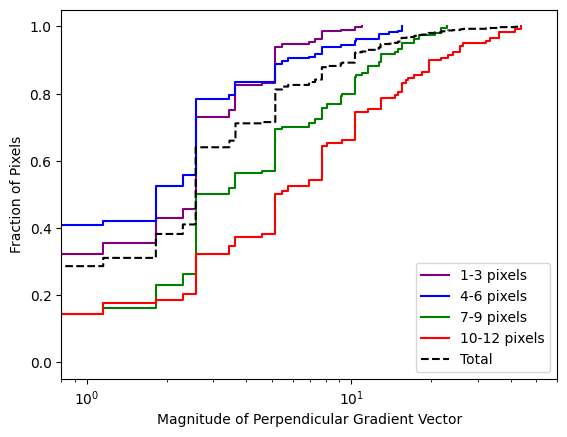

In [111]:
vec_mag_low = []
vec_mag_med = []
vec_mag_high = []
vec_mag_higher = []
total_vec_mag = []

for i in range(lon_length):
    for j in range(lat_length):
        if 1 <= subregion_spines[j][i] <= 3:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_8.append(subregion_spines[j][i])
                vec_mag_low.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 4 <= subregion_spines[j][i] <= 6:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_7.append(subregion_spines[j][i])
                vec_mag_med.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 7 <= subregion_spines[j][i] <= 9:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_6.append(subregion_spines[j][i])
                vec_mag_high.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 10 <= subregion_spines[j][i] <= 12:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_5.append(subregion_spines[j][i])
                vec_mag_higher.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))

plt.ecdf(vec_mag_low, label = '1-3 pixels', color = 'purple')
plt.ecdf(vec_mag_med, label = '4-6 pixels', color = 'blue')
plt.ecdf(vec_mag_high, label = '7-9 pixels', color = 'green')
plt.ecdf(vec_mag_higher, label = '10-12 pixels', color = 'red')
plt.ecdf(total_vec_mag, label = 'Total', linestyle = 'dashed', color = 'black')

plt.xscale('log')
plt.xlim(0.8, 60)
plt.ylim(-0.05, 1.05)
#plt.text(0.1, 0.4, region, fontsize = 16, fontweight = 'bold')

plt.legend(loc = 'lower right')
plt.xlabel('Magnitude of Perpendicular Gradient Vector')
plt.ylabel('Fraction of Pixels')

### Rotate the Differential 0-Forms for Parallel Gradients

Let's start by just looking at the differential 0 forms. Then, we need to figure out a way to rotate by 90$^\circ$ in one direction above the spine and then by -90$^\circ$ below the spine so that there is a flow around the spine. I think a good starting point will be to identify the pixels where the spine is located. Then through a conditional statement, figure out some way to rotate the gradient vectors based on the relationship of their location to the spine. Once we've done this, then we should set a limit of ~8 pixels where we no longer measure the parallel gradient. Check Mike Chen's paper to see how far away from the spine he went.

30 30
30 30
[0.         0.5        0.70710678 1.         1.11803399 1.41421356]


/tmp/ipykernel_362879/2342883384.py:57: RuntimeWarning: invalid value encountered in scalar divide
  proj_length = (par_x_spines[i][j] * grad_x_vel[i][j] + par_y_spines[i][j] * grad_y_vel[i][j])/np.sqrt((par_x_spines[i][j])**2 +


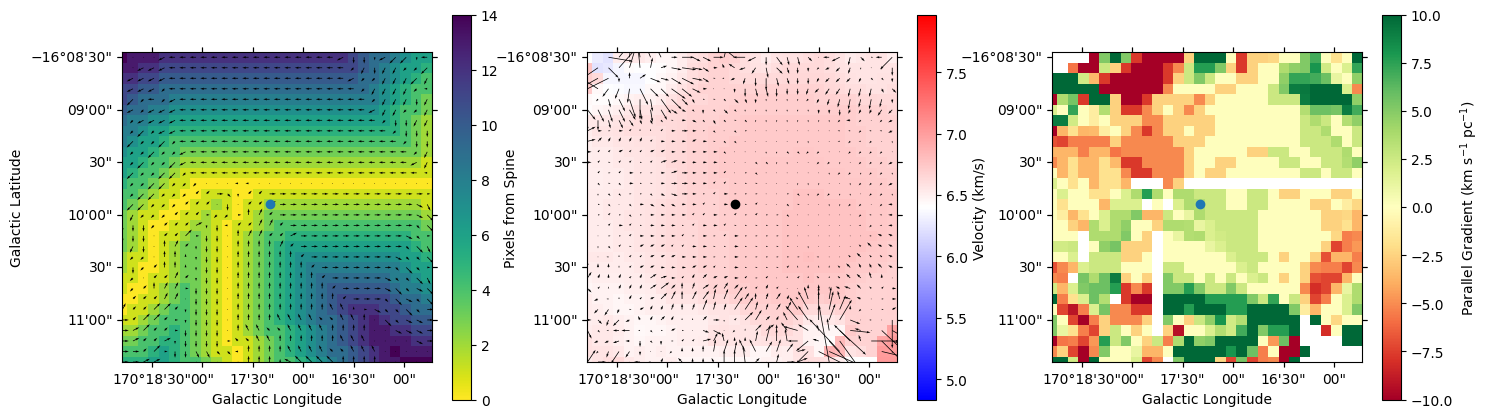

In [114]:
def divergence(scalar_field):
    gy, gx = np.gradient(scalar_field)
    print(len(gx[0]), len(gy[0]))
    return(gy, gx)

lon_length, lat_length = 30, 30
lon_start, lat_start = 14, 86

subregion_spines = distance_transform_data[round(b_min + lat_start):round(b_min + lat_start + lat_length), round(l_min + lon_start):round(l_min + lon_start + lon_length)]
grad_y_spines, grad_x_spines = divergence(subregion_spines) #Flip the order because the coordinates get put in (b, l) and not (l, b)
print(len(grad_x_spines), len(grad_y_spines))
#print(len(grad_x_spines[0]))

x = np.arange(0, lon_length, 1)
y = np.arange(0, lat_length, 1)

X, Y = np.meshgrid(x,y)

x_0 = []
y_0 = []
for i in range(lat_length):
    for j in range(lon_length):
        if subregion_spines[i][j] == 0:
            x_0.append(j)
            y_0.append(i)
            #print(i, j, grad_x_spines[i][j], grad_y_spines[i][j])

par_x_spines = []
par_y_spines = []
diff_1_form_mag = []
for i in range(lat_length):
    x_place = []
    y_place = []
    for j in range(lon_length):
        #print(j, i, list(x_0).index(j), y_0[list(x_0).index(j)]) 
        #print x coord, y coord, the index of the spine in that column, the y coordinate of the spine in that column
        if subregion_spines[i][j] <= 12:
            x_place.append(float(-grad_y_spines[i][j]))
            y_place.append(float(grad_x_spines[i][j]))
            diff_1_form_mag.append(np.sqrt(grad_y_spines[i][j]**2 + grad_x_spines[i][j]**2))
        else:
            x_place.append(float(0))
            y_place.append(float(0))
    par_x_spines.append(np.array(x_place))
    par_y_spines.append(np.array(y_place))

print(np.unique(diff_1_form_mag))

para_grad_x = []
para_grad_y = []
x_vals = []
y_vals = []
divergence = []
for i in range(len(y)):
    summed = []
    for j in range(len(x)):
        proj_length = (par_x_spines[i][j] * grad_x_vel[i][j] + par_y_spines[i][j] * grad_y_vel[i][j])/np.sqrt((par_x_spines[i][j])**2 + 
                                                                                                       (par_y_spines[i][j])**2)
        #magnitude = np.sqrt((par_x_spines[i][j] * proj_length)**2 + (par_y_spines[i][j] * proj_length)**2)

        if magnitude <= 0.2:
            #Do something
        
            para_grad_x.append(par_x_spines[i][j] * proj_length)
            para_grad_y.append(par_y_spines[i][j] * proj_length)

            x_vals.append(x[j])
            y_vals.append(y[i])

        summed.append(proj_length/0.0039)
        #summed.append(np.sqrt((par_x_spines[i][j] * proj_length)**2 + (par_y_spines[i][j] * proj_length)**2))
        #else:
            #summed.append(subregion_vel[0][0])
            #print(subregion_vel[0][0])
        
    divergence.append(summed)

plt.figure(figsize = [17, 5])

ax_3 = plt.subplot(133, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_3.imshow(divergence, cmap = 'RdYlGn', vmin = -10, vmax = 10)#0.2)
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_3.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_3.set(xlim=(0,29.5), ylim=(0, 29.5))
cbar = plt.colorbar(im, label = r'Parallel Gradient (km s$^{-1}$ pc$^{-1}$)')

ax_2 = plt.subplot(132, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_2.imshow(subregion_vel, cmap = 'bwr', vmin = np.nanmin(blue_data), vmax = np.nanmax(blue_data))
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude', c = 'white')
ax_2.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start, color = 'black')
ax_2.set(xlim=(0,29.5), ylim=(0, 29.5))
plt.quiver(X, Y, grad_x_vel, grad_y_vel, color = 'black')
cbar = plt.colorbar(im, label = 'Velocity (km/s)')

ax_1 = plt.subplot(131, projection = wcs_blue, slices=('x', 'y', 0))
im = ax_1.imshow(subregion_spines, cmap = 'viridis_r', vmax = np.nanmax(subregion_spines))
#plt.quiver(x_vals, y_vals, grad_x_spines, grad_y_spines, color = 'black')
plt.quiver(X, Y, par_x_spines, par_y_spines, color = 'black')
#plt.quiver(X, Y, par_x_spines, par_y_spines, color = 'black')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
cbar = plt.colorbar(im, label = 'Pixels from Spine')
ax_1.scatter(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
#print(pixels_x_vel-lon_start, pixels_y_vel-lat_start)
ax_1.set(xlim=(0,29.5), ylim=(0, 29.5))
#ax_1.text(2, 2, 'Parallel 0-Form', size = 12, color = 'white', fontweight = 'bold')

plt.savefig('Figures/Seo33_parallel_triptych.png', transparent=True, bbox_inches = 'tight')

Text(0, 0.5, 'Fraction of Pixels')

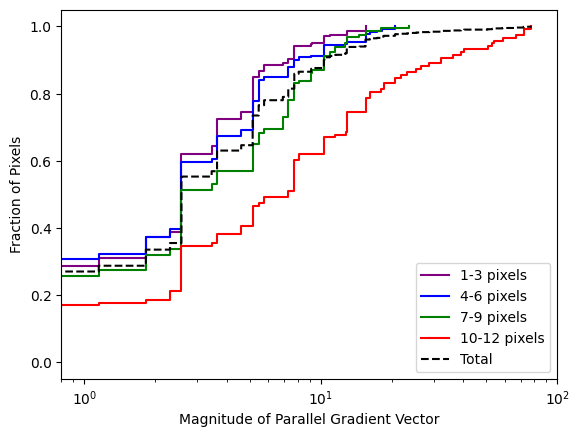

In [82]:
vec_mag_low = []
vec_mag_med = []
vec_mag_high = []
vec_mag_higher = []
total_vec_mag = []

for i in range(lon_length):
    for j in range(lat_length):
        if 1 <= subregion_spines[j][i] <= 3:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_8.append(subregion_spines[j][i])
                vec_mag_low.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 4 <= subregion_spines[j][i] <= 6:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_7.append(subregion_spines[j][i])
                vec_mag_med.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 7 <= subregion_spines[j][i] <= 9:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_6.append(subregion_spines[j][i])
                vec_mag_high.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))
        elif 10 <= subregion_spines[j][i] <= 12:
            if math.isnan(divergence[j][i]) == False:
                #dist_spine_5.append(subregion_spines[j][i])
                vec_mag_higher.append(np.abs(divergence[j][i]))
                total_vec_mag.append(np.abs(divergence[j][i]))

plt.ecdf(vec_mag_low, label = '1-3 pixels', color = 'purple')
plt.ecdf(vec_mag_med, label = '4-6 pixels', color = 'blue')
plt.ecdf(vec_mag_high, label = '7-9 pixels', color = 'green')
plt.ecdf(vec_mag_higher, label = '10-12 pixels', color = 'red')
plt.ecdf(total_vec_mag, label = 'Total', linestyle = 'dashed', color = 'black')

plt.xscale('log')
plt.xlim(0.8, 100)
plt.ylim(-0.05, 1.05)
#plt.text(0.1, 0.4, region, fontsize = 16, fontweight = 'bold')

plt.legend(loc = 'lower right')
plt.xlabel('Magnitude of Parallel Gradient Vector')
plt.ylabel('Fraction of Pixels')